# Income Classification: 
The goal of this project is to develop an accurate and robust classifier that predicts whether an individual's income exceeds $50,000 based on demographic and work-related features from census data. 

# Part I. Exploratory Data Analysis

**Key objectives:**
- Clean and preprocess the dataset
- Analyze the main drivers of income

## Table of Contents
    1. Data Overview
        - Data sources and dictionary
        - Initial data exploration
      
    2. Exploratory Data Analysis (EDA)
        - Identification of outliers
        - Feature distributions (numerical & categorical)
        - Correlation analysis
        - Identification of missing values
        - Missing value replacement and column filtering

    3. Preprocessing & Feature Engineering
        - Handling missing values (imputation strategies)
        - Categorical variable grouping and encoding
        - Feature selection and transformation
---

> _All steps are implemented in a reproducible and modular fashion for further deployment and monitoring._


In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import chi2_contingency

# 1. Data Overview & cleaning
 - Target Variable Distribution
 - Categorical Variables Exploration
 - Numeric Variable Analysis
 - Duplicates removal

In [3]:
# Load column_names 
column_names = [
    'age', 'class_of_worker', 'detailed_industry_recode', 'detailed_occupation_recode',
    'education', 'wage_per_hour', 'enroll_in_edu_last_wk', 'marital_stat',
    'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin',
    'sex', 'member_of_labor_union', 'reason_for_unemployment', 'full_or_part_time_stat',
    'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_stat',
    'region_prev_residence', 'state_prev_residence', 'household_family_stat', 'household_summary',
    'instance_weight',  # Ignore
    'msa_change_code', 'reg_change_code', 'move_within_reg', 'live_in_this_house_1_year_ago',
    'prev_residence_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18',
    'country_birth_father', 'country_birth_mother', 'country_birth_self', 'citizenship',
    'own_business_or_self_employed', 'veterans_admin_questionnaire', 'veterans_benefits',
    'weeks_worked_in_year', 'year', 'income'
]

# Read data
train_df = pd.read_csv("data/census_income_learn.csv", header=None, names=column_names)
test_df = pd.read_csv("data/census_income_test.csv", header=None, names=column_names)

# Suppression of instance_weight
train_df.drop(columns=["instance_weight"], inplace=True)
test_df.drop(columns=["instance_weight"], inplace=True)

#### A. Target Variable Distribution

Distribution of the target variable (`income`) in both the train and test sets, to check for class imbalance.


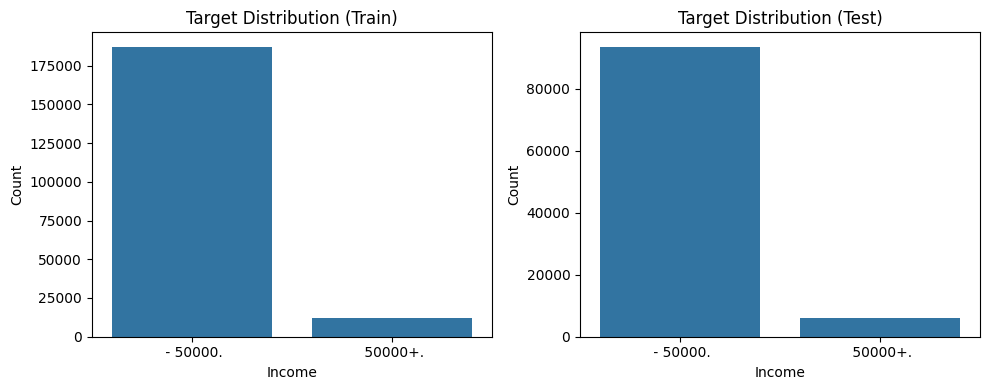

In [4]:
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
sns.countplot(x='income', data=train_df)
plt.title('Target Distribution (Train)')
plt.xlabel('Income')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='income', data=test_df)
plt.title('Target Distribution (Test)')
plt.xlabel('Income')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

---
*Large imbalance, we need to take that into consideration in the training.*

---

#### B.1. Categorical Variables Exploration

For each categorical variable, we examine the number of unique values and their distribution.

This analysis serves to:
- Identify non-informative or missing value codes which will be standardized as `NaN` for consistency.
- Detect possible typos, anomalies, or aberrant values (e.g., inconsistent spelling or formatting).

In [5]:
cat_cols = train_df.select_dtypes(include='object').columns
# Print unique values
for col in cat_cols:
    print(f"\n🔹 Column : {col}")
    uniques = train_df[col].unique()
    print(f"Nb of unique values : {len(uniques)}")
    print(f"Values : {uniques}")


🔹 Column : class_of_worker
Nb of unique values : 9
Values : [' Not in universe' ' Self-employed-not incorporated' ' Private'
 ' Local government' ' Federal government' ' Self-employed-incorporated'
 ' State government' ' Never worked' ' Without pay']

🔹 Column : education
Nb of unique values : 17
Values : [' High school graduate' ' Some college but no degree' ' 10th grade'
 ' Children' ' Bachelors degree(BA AB BS)'
 ' Masters degree(MA MS MEng MEd MSW MBA)' ' Less than 1st grade'
 ' Associates degree-academic program' ' 7th and 8th grade'
 ' 12th grade no diploma' ' Associates degree-occup /vocational'
 ' Prof school degree (MD DDS DVM LLB JD)' ' 5th or 6th grade'
 ' 11th grade' ' Doctorate degree(PhD EdD)' ' 9th grade'
 ' 1st 2nd 3rd or 4th grade']

🔹 Column : enroll_in_edu_last_wk
Nb of unique values : 3
Values : [' Not in universe' ' High school' ' College or university']

🔹 Column : marital_stat
Nb of unique values : 7
Values : [' Widowed' ' Divorced' ' Never married'
 ' Married-c

---
*`?`, `Not identifiable`, `NA`, `Do not know` have to be converted to missing values.*

---

#### B.2. Numeric Variable Analysis

We review the range and cardinality of all numeric features to:
- Detect possible outliers or abnormal values
- Identify numerical columns that are actually categorical codes (e.g., industry or occupation codes, year)
- Prepare for appropriate type conversion to ensure proper handling by classification models

In [6]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    print(f"{col}: min={train_df[col].min()}, max={train_df[col].max()}, unique={train_df[col].nunique()}")

age: min=0, max=90, unique=91
detailed_industry_recode: min=0, max=51, unique=52
detailed_occupation_recode: min=0, max=46, unique=47
wage_per_hour: min=0, max=9999, unique=1240
capital_gains: min=0, max=99999, unique=132
capital_losses: min=0, max=4608, unique=113
dividends_from_stocks: min=0, max=99999, unique=1478
num_persons_worked_for_employer: min=0, max=6, unique=7
own_business_or_self_employed: min=0, max=2, unique=3
veterans_benefits: min=0, max=2, unique=3
weeks_worked_in_year: min=0, max=52, unique=53
year: min=94, max=95, unique=2


---
*Based on analysis and documentation, the variables `detailed_industry_recode`, `detailed_occupation_recode`, `own_business_or_self_employed`, `veterans_benefits`, and `year` should be converted to categorical types.*

---

#### C. Duplicates removal

In [7]:
def clean_string_columns(df):
    """Strip whitespace from all string columns."""
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.strip()
    return df

def replace_missing_values(df, missing_values):
    """Replace custom missing value codes with np.nan."""
    return df.replace(missing_values, np.nan)

def convert_to_category(df, columns):
    """Convert selected columns to categorical dtype."""
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype('category')
    return df

def remove_duplicates(df):
    """Remove duplicate rows from the dataframe and return new df + n removed."""
    original_len = df.shape[0]
    df = df.drop_duplicates()
    removed = original_len - df.shape[0]
    print(f"✅ Removed {removed} duplicate rows.")
    return df

In [8]:
MISSING_VALUES = [
    '?',
    'Not in universe',
    'Not identifiable',
    'NA',
    'Do not know'
]

cat_cols_to_convert = [
    'detailed_industry_recode',   
    'detailed_occupation_recode', 
    'own_business_or_self_employed', 
    'veterans_benefits',        
    'year'
]

# Cleaning pipeline
train_df = clean_string_columns(train_df)
test_df = clean_string_columns(test_df)

train_df = replace_missing_values(train_df, MISSING_VALUES)
test_df = replace_missing_values(test_df, MISSING_VALUES)

train_df = convert_to_category(train_df, cat_cols_to_convert)
test_df = convert_to_category(test_df, cat_cols_to_convert)

# Remove duplicates 
train_df = remove_duplicates(train_df)
test_df = remove_duplicates(test_df)

✅ Removed 46641 duplicate rows.
✅ Removed 20902 duplicate rows.


# 2. EDA
    - A. Identification of outliers
    - B. Identification of missing value patterns
    - C. Drop Columns with Excessive Missing Values
    - D. Correlation analysis
    - E. Duplicates



### A. dentification of outliers
#### numerical variables

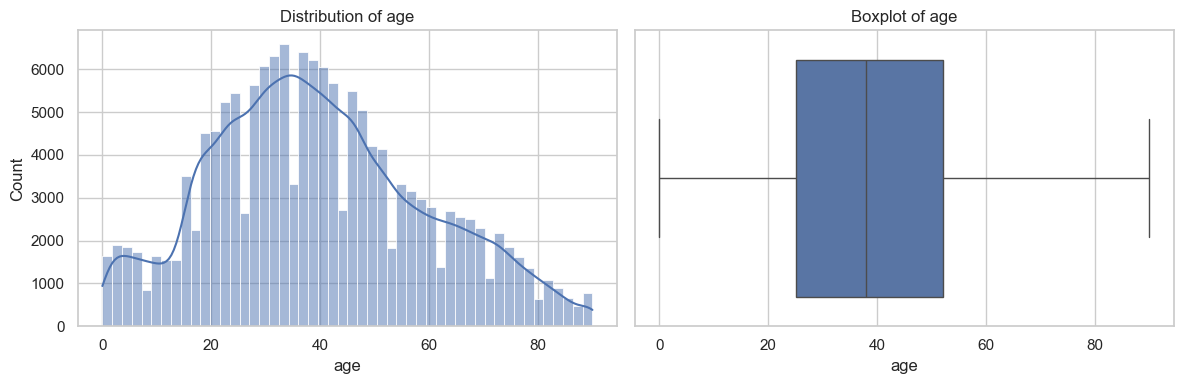

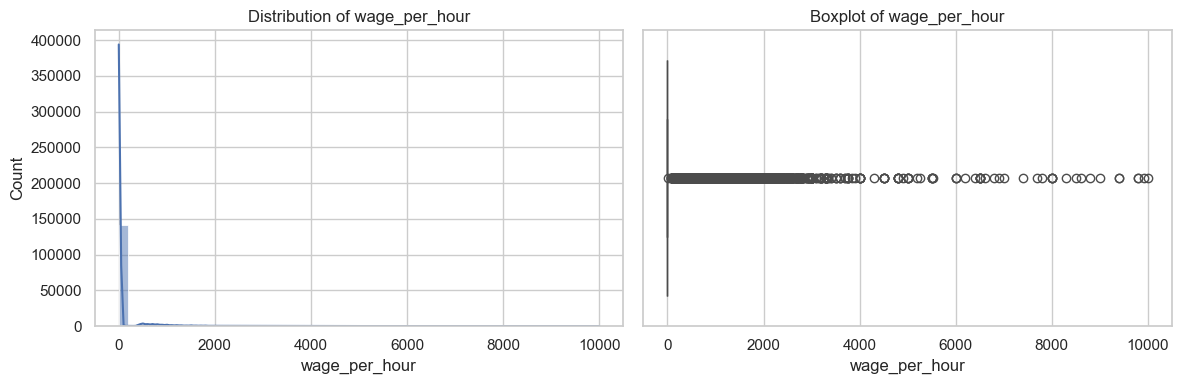

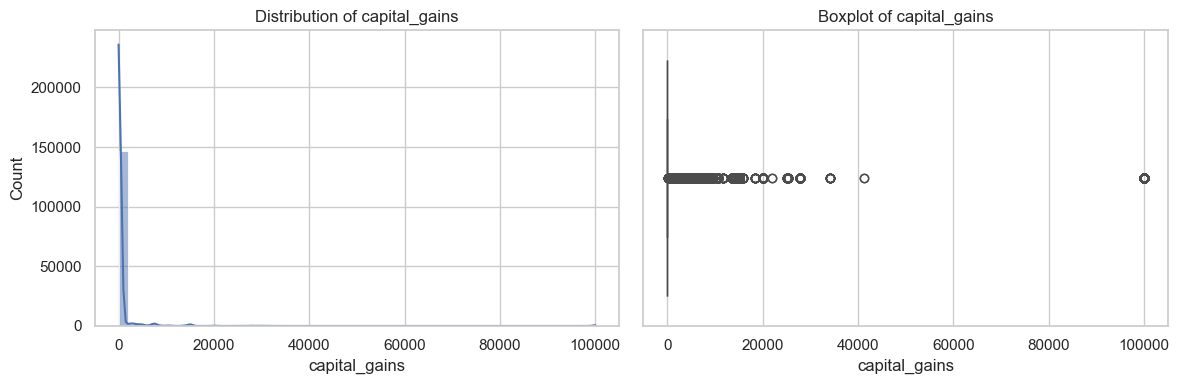

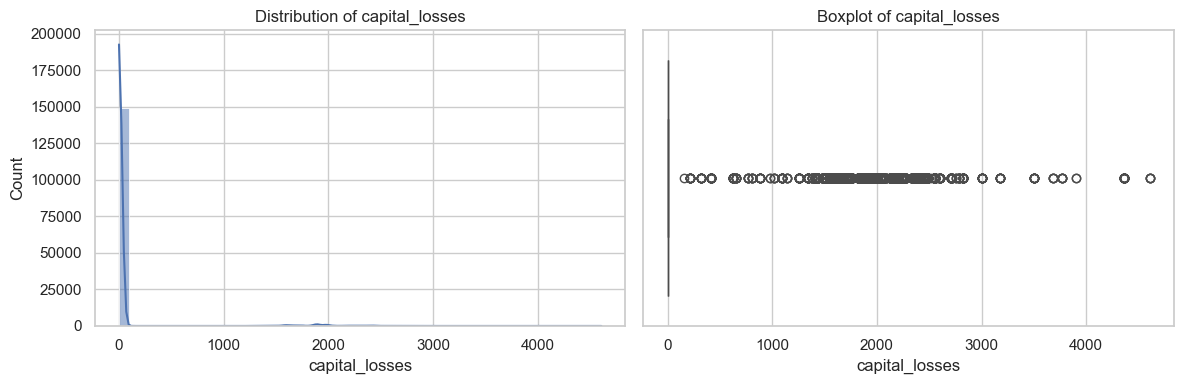

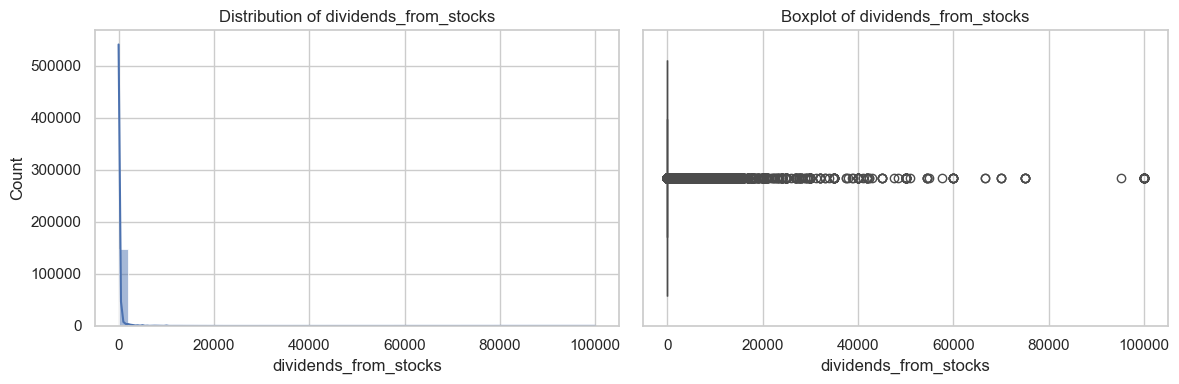

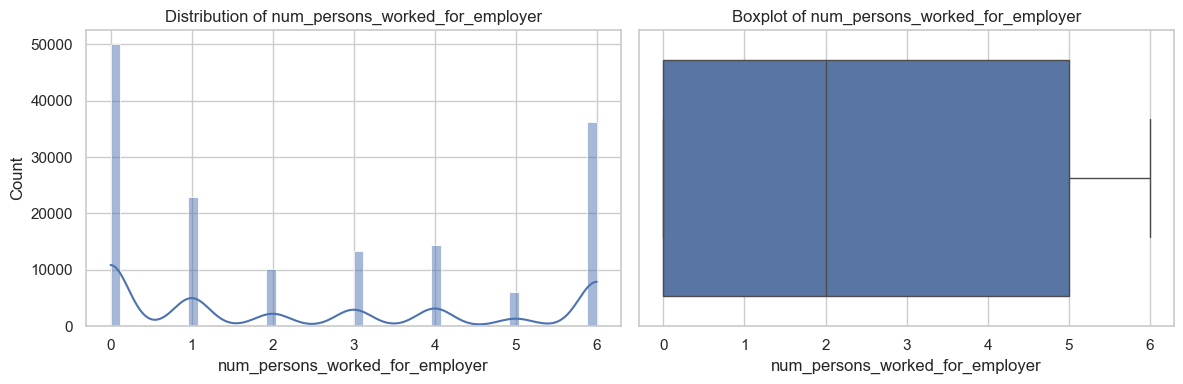

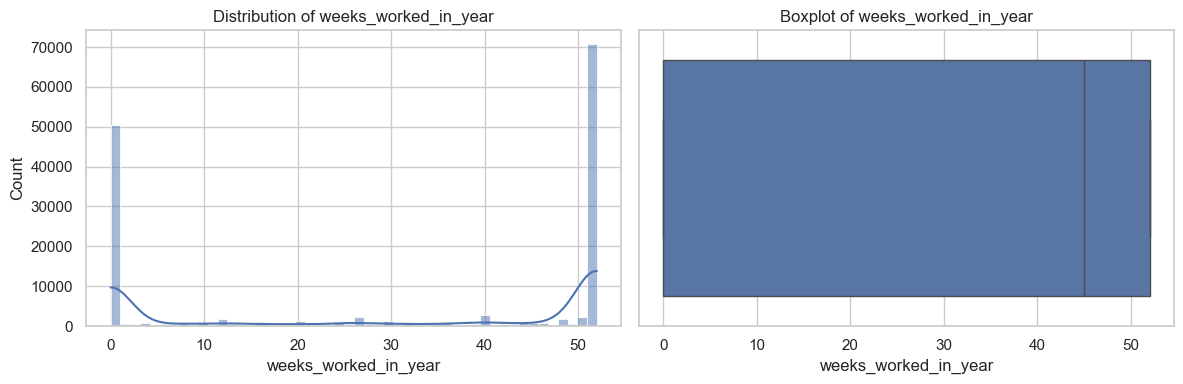

In [9]:
# Set visual style
sns.set(style="whitegrid")

# Select numeric columns
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns

# Plot distributions and boxplots
for col in numeric_cols:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(train_df[col].dropna(), bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f"Distribution of {col}")

    sns.boxplot(x=train_df[col], ax=axs[1])
    axs[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

#### Categorical variables


🔹 class_of_worker — Unique values: 8
Top values:
class_of_worker
Private                           71738
NaN                               54151
Self-employed-not incorporated     8321
Local government                   7726
State government                   4221


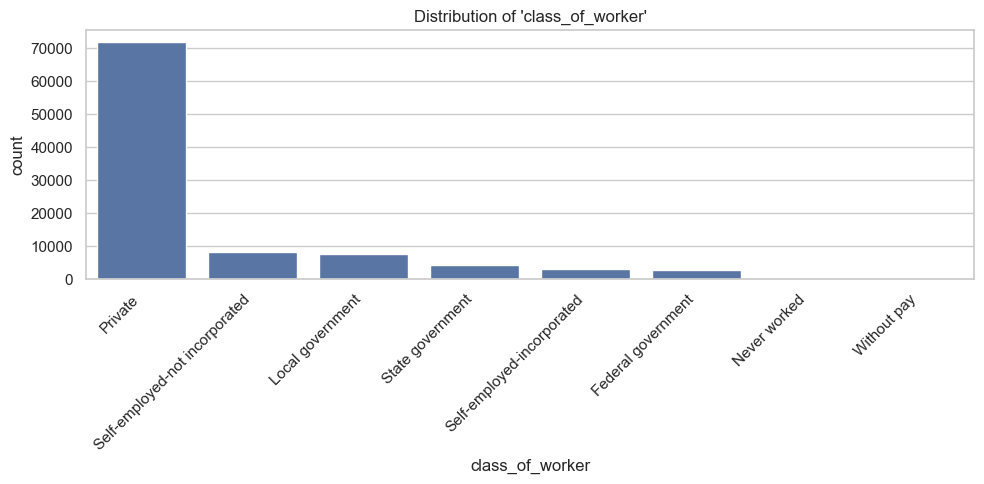


🔹 detailed_industry_recode — Unique values: 52
Top values:
detailed_industry_recode
0     54534
33    16892
43     8223
4      5943
42     4670


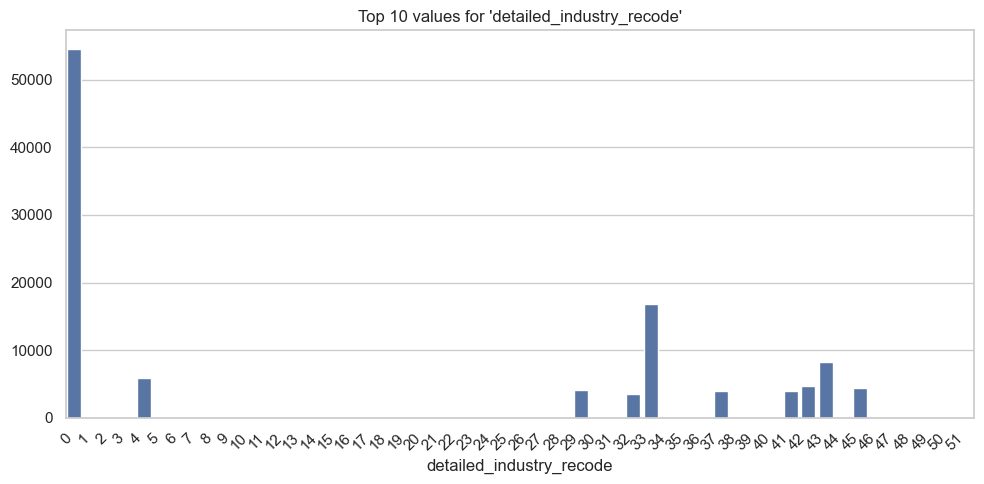


🔹 detailed_occupation_recode — Unique values: 47
Top values:
detailed_occupation_recode
0     54534
2      8749
26     7868
19     5337
29     5070


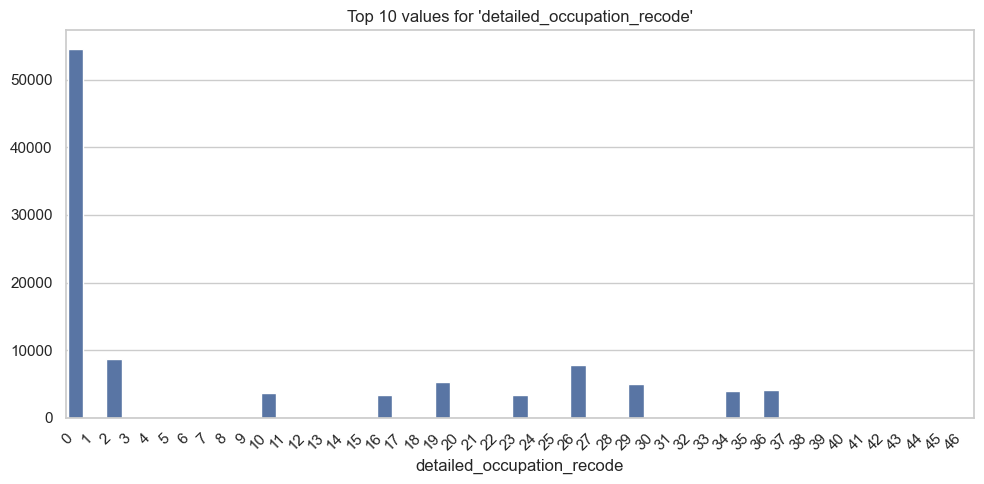


🔹 education — Unique values: 17
Top values:
education
High school graduate          43642
Some college but no degree    26329
Bachelors degree(BA AB BS)    19391
Children                      12696
10th grade                     6487


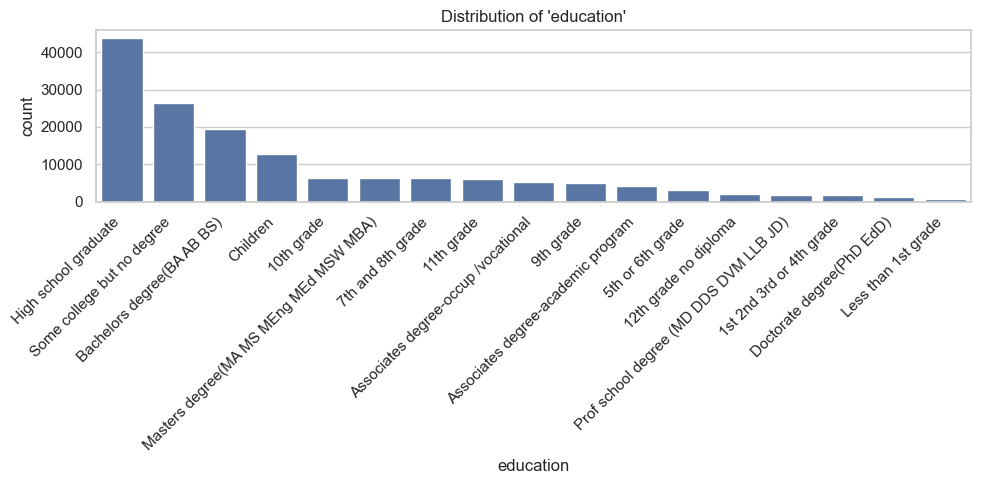


🔹 enroll_in_edu_last_wk — Unique values: 2
Top values:
enroll_in_edu_last_wk
NaN                      142229
High school                5331
College or university      5322


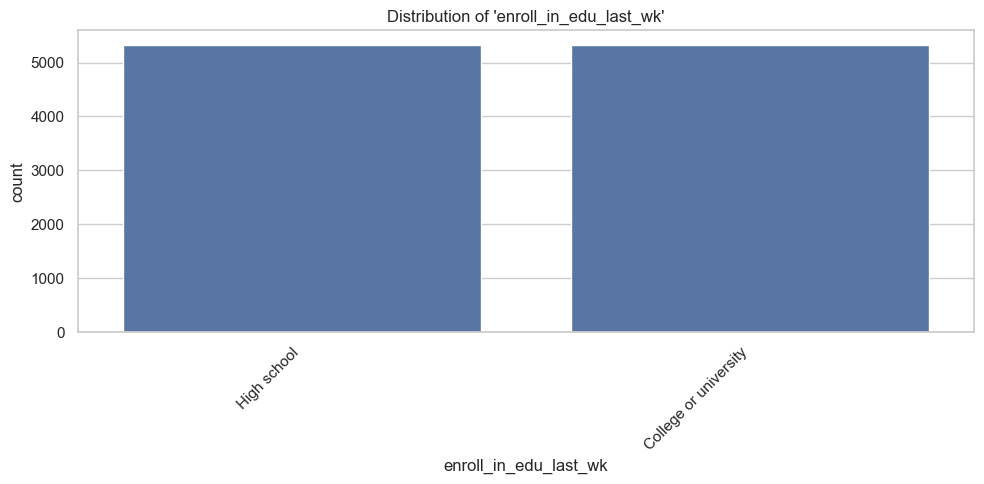


🔹 marital_stat — Unique values: 7
Top values:
marital_stat
Married-civilian spouse present    77842
Never married                      48059
Divorced                           12504
Widowed                             8873
Separated                           3430


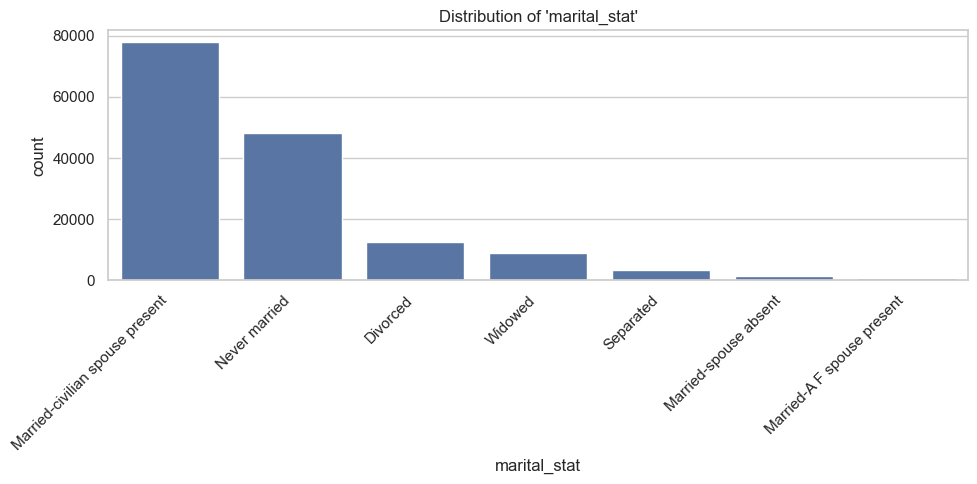


🔹 major_industry_code — Unique values: 24
Top values:
major_industry_code
Not in universe or children       54534
Retail trade                      16892
Manufacturing-durable goods        9007
Education                          8223
Manufacturing-nondurable goods     6892


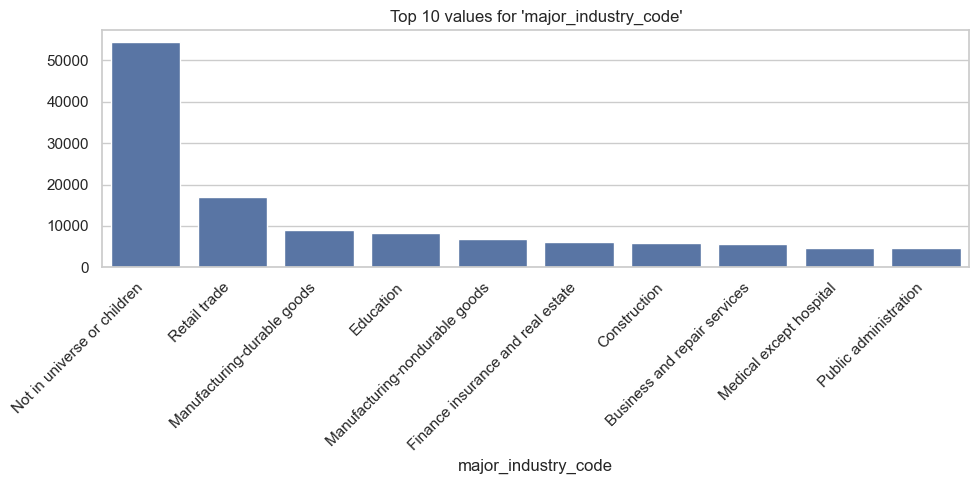


🔹 major_occupation_code — Unique values: 14
Top values:
major_occupation_code
NaN                               54534
Adm support including clerical    14797
Professional specialty            13866
Executive admin and managerial    12483
Other service                     12034


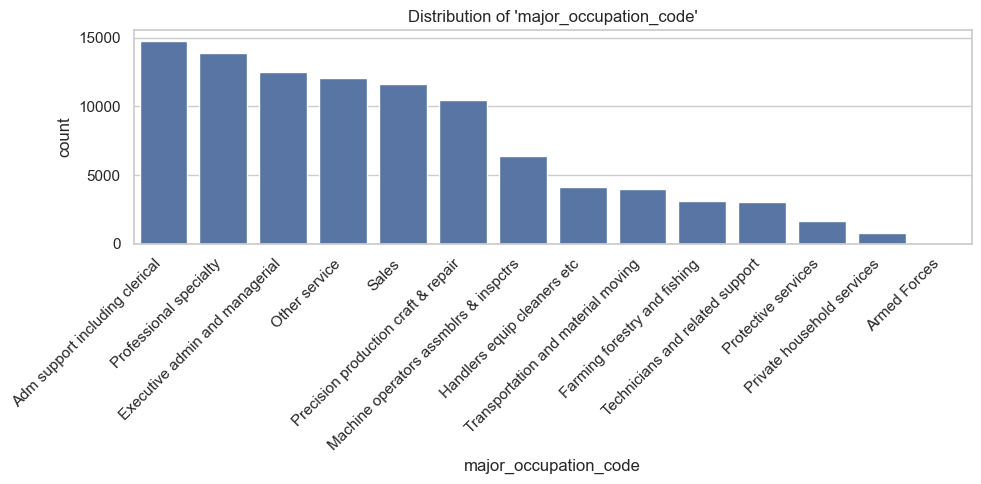


🔹 race — Unique values: 5
Top values:
race
White                          126994
Black                           15074
Asian or Pacific Islander        5502
Other                            3439
Amer Indian Aleut or Eskimo      1873


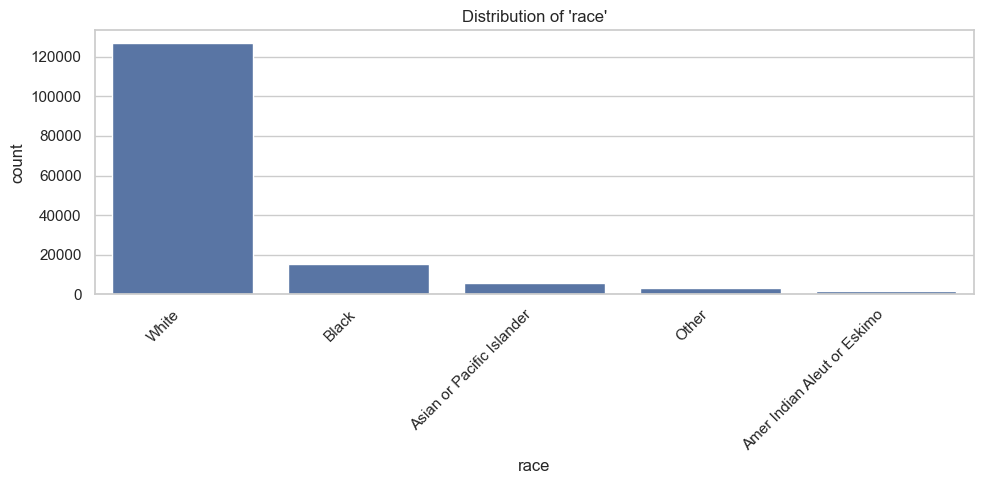


🔹 hispanic_origin — Unique values: 8
Top values:
hispanic_origin
All other                    128819
Mexican (Mexicano)             6310
Mexican-American               6026
Central or South American      3804
Puerto Rican                   3064


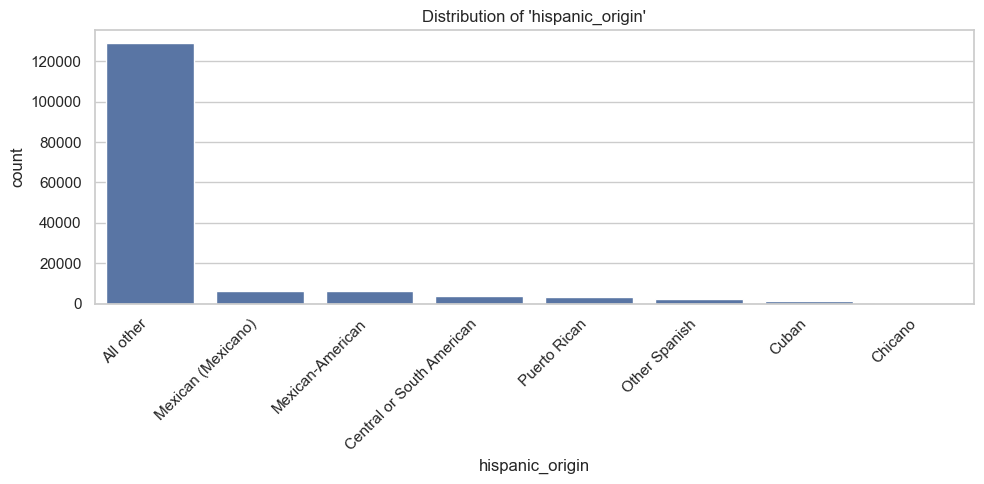


🔹 sex — Unique values: 2
Top values:
sex
Female    78702
Male      74180


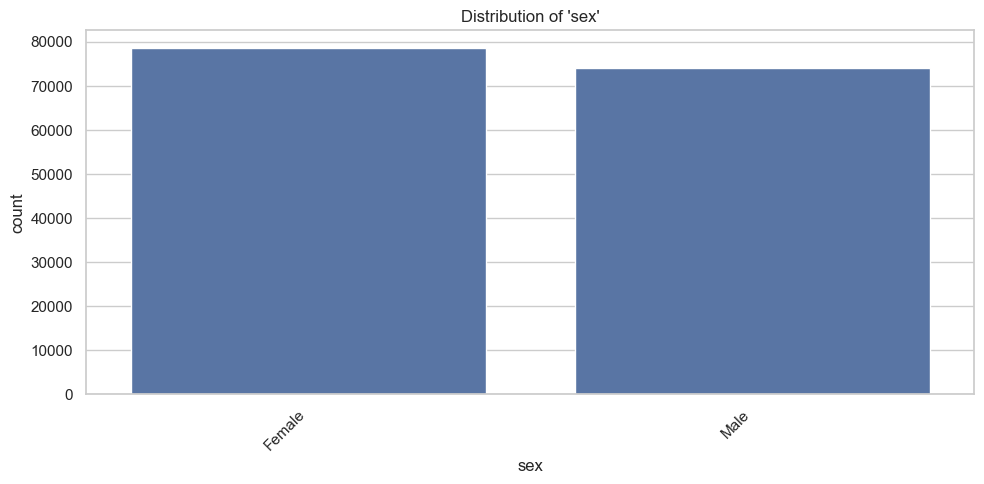


🔹 member_of_labor_union — Unique values: 2
Top values:
member_of_labor_union
NaN    133826
No      16028
Yes      3028


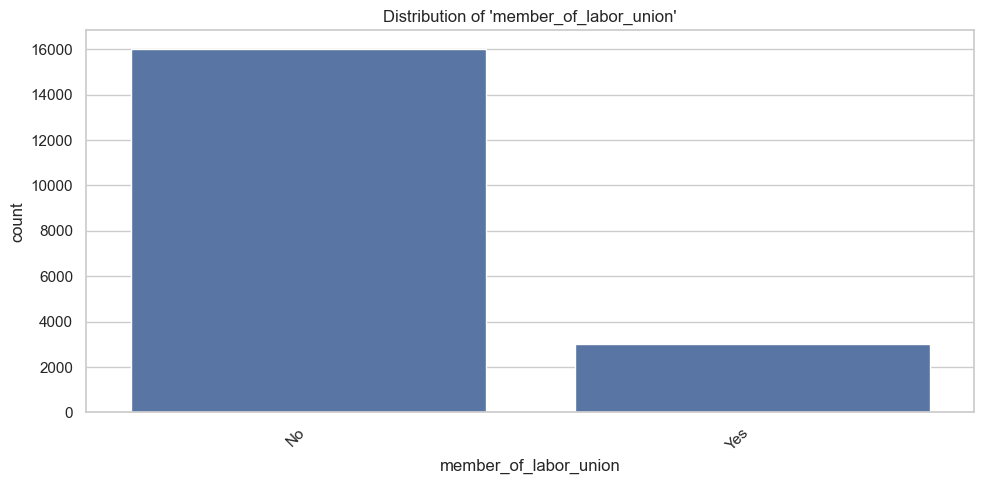


🔹 reason_for_unemployment — Unique values: 5
Top values:
reason_for_unemployment
NaN                      146870
Other job loser            2038
Re-entrant                 2017
Job loser - on layoff       976
Job leaver                  598


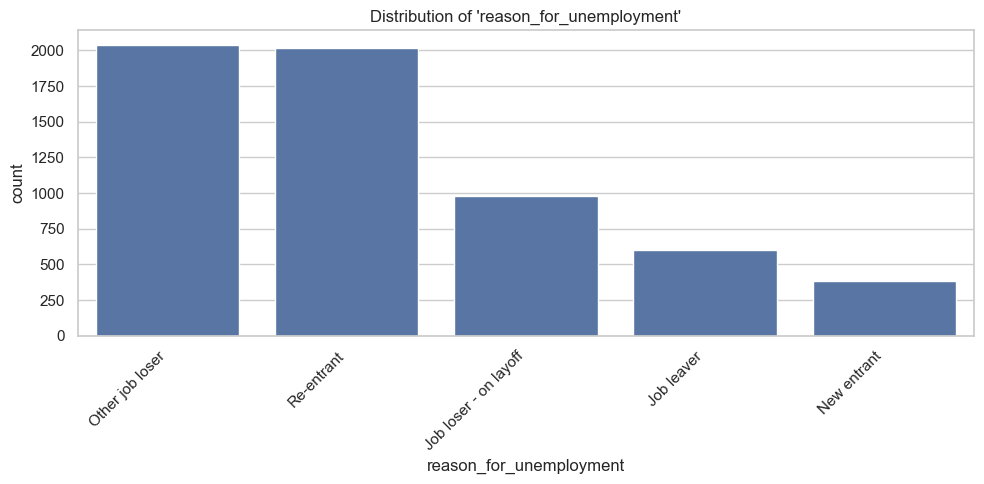


🔹 full_or_part_time_stat — Unique values: 8
Top values:
full_or_part_time_stat
Children or Armed Forces              83327
Full-time schedules                   40477
Not in labor force                    20900
PT for non-econ reasons usually FT     3322
Unemployed full-time                   2308


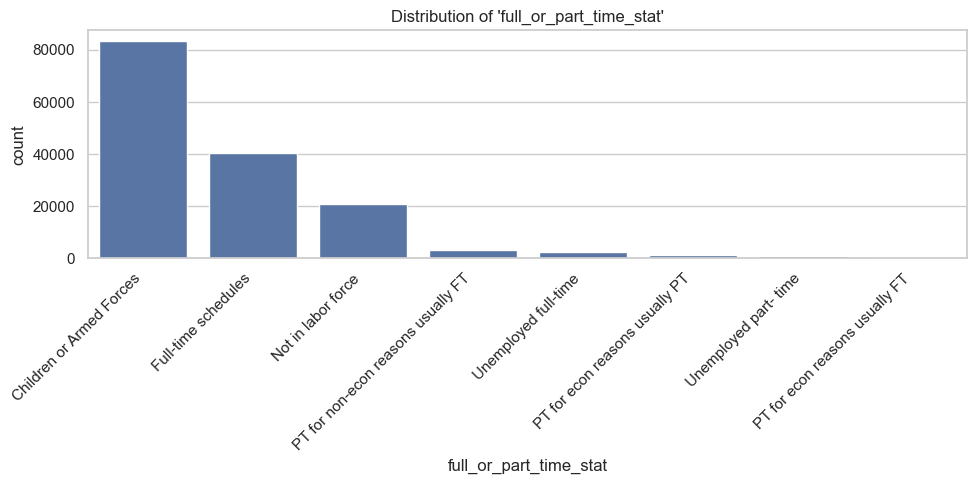


🔹 tax_filer_stat — Unique values: 6
Top values:
tax_filer_stat
Joint both under 65    64159
Single                 36576
Nonfiler               34718
Head of household       7417
Joint both 65+          6556


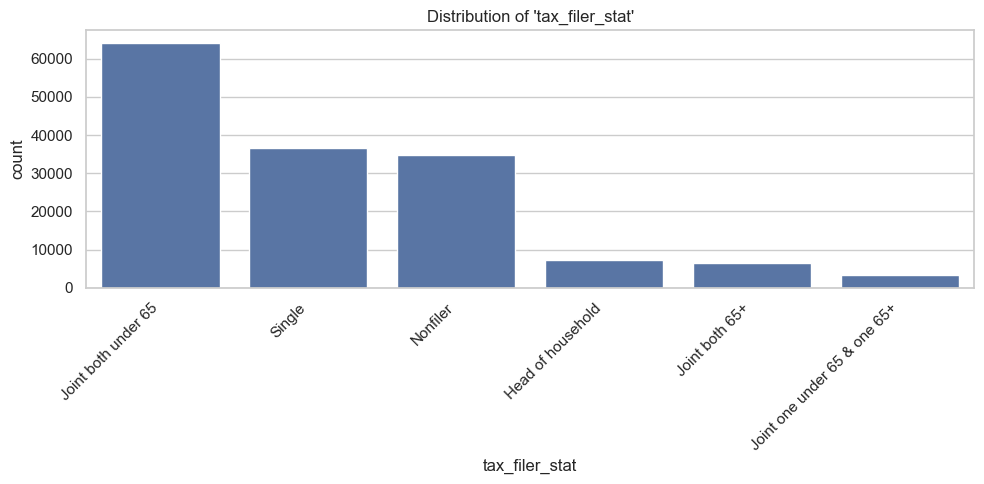


🔹 region_prev_residence — Unique values: 5
Top values:
region_prev_residence
NaN          137478
South          4768
West           3997
Midwest        3451
Northeast      2661


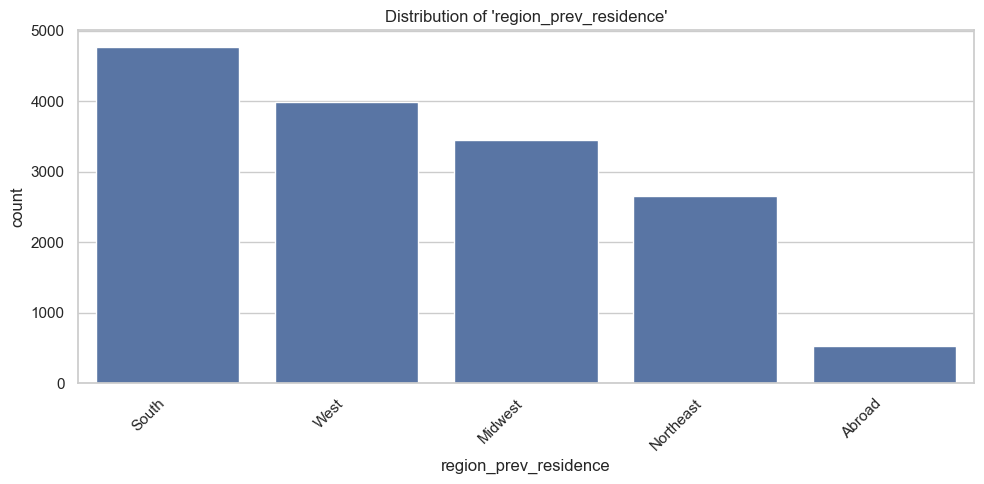


🔹 state_prev_residence — Unique values: 49
Top values:
state_prev_residence
NaN               138176
California          1669
Utah                1026
Florida              814
North Carolina       792


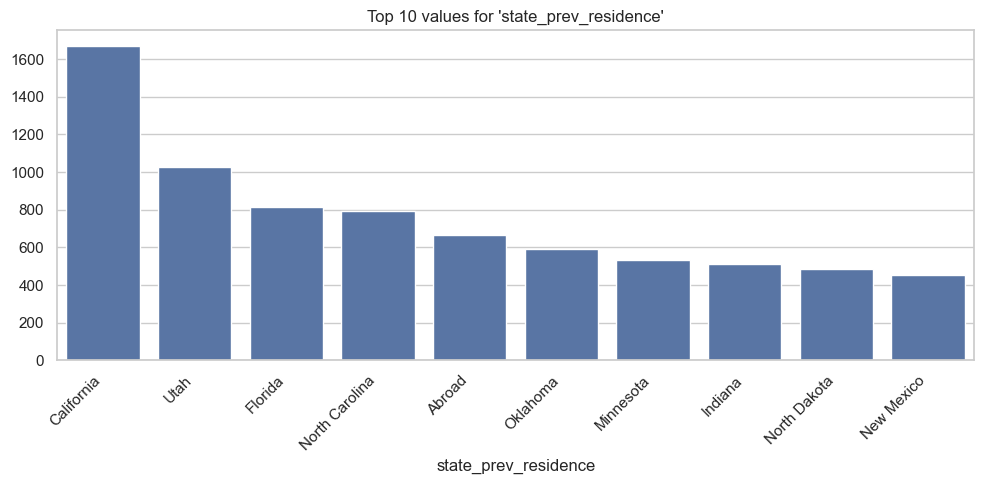


🔹 household_family_stat — Unique values: 38
Top values:
household_family_stat
Householder                                51118
Spouse of householder                      37151
Nonfamily householder                      20629
Child <18 never marr not in subfamily      15171
Child 18+ never marr Not in a subfamily    11344


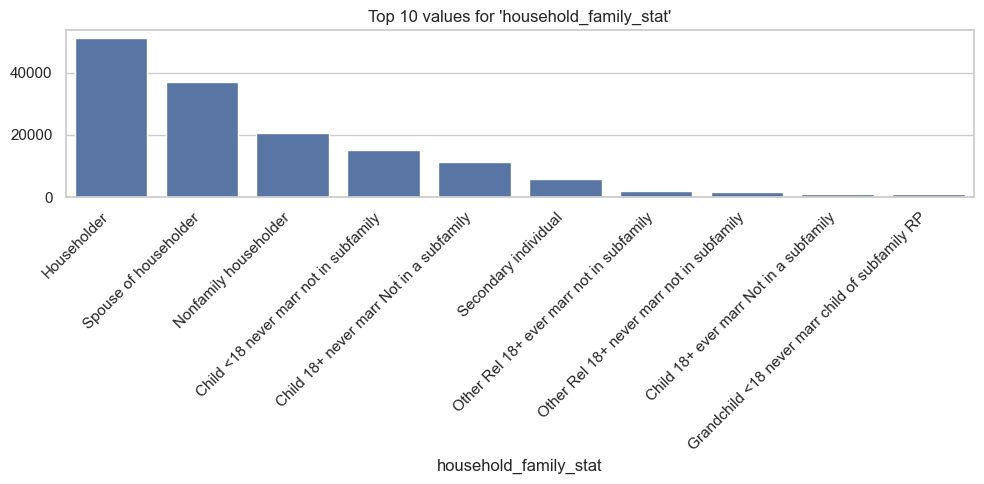


🔹 household_summary — Unique values: 8
Top values:
household_summary
Householder                      71761
Spouse of householder            37165
Child under 18 never married     15267
Child 18 or older                13719
Other relative of householder     7690


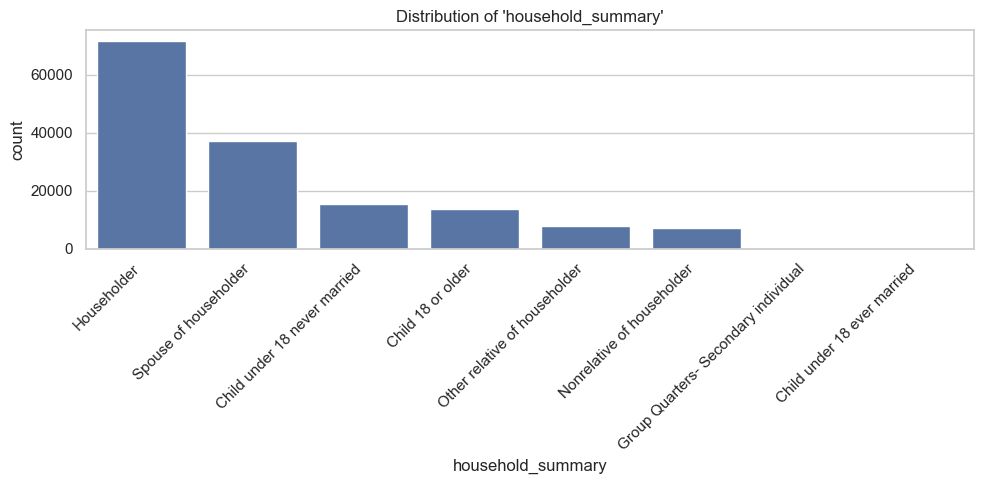


🔹 msa_change_code — Unique values: 7
Top values:
msa_change_code
NaN                 75711
Nonmover            62191
MSA to MSA          10299
NonMSA to nonMSA     2759
MSA to nonMSA         784


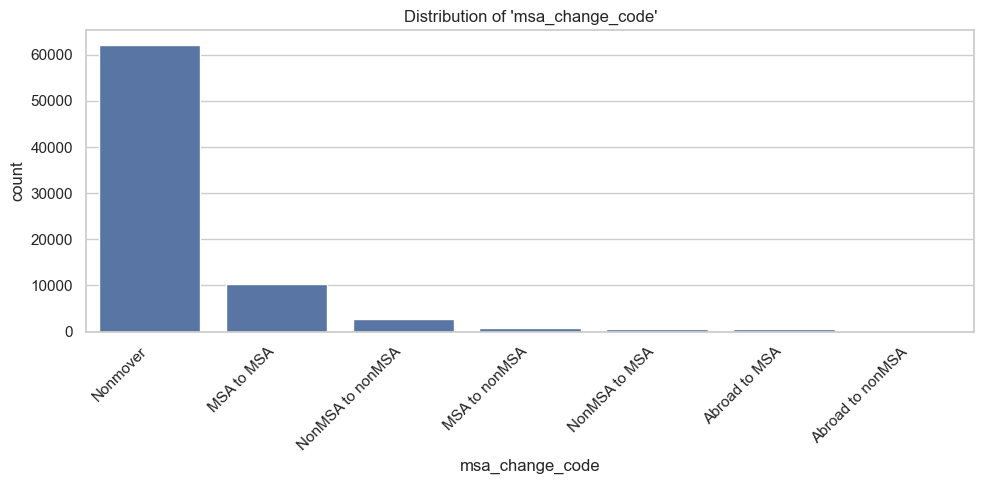


🔹 reg_change_code — Unique values: 7
Top values:
reg_change_code
NaN                            75287
Nonmover                       62191
Same county                     9479
Different county same state     2773
Different region                1173


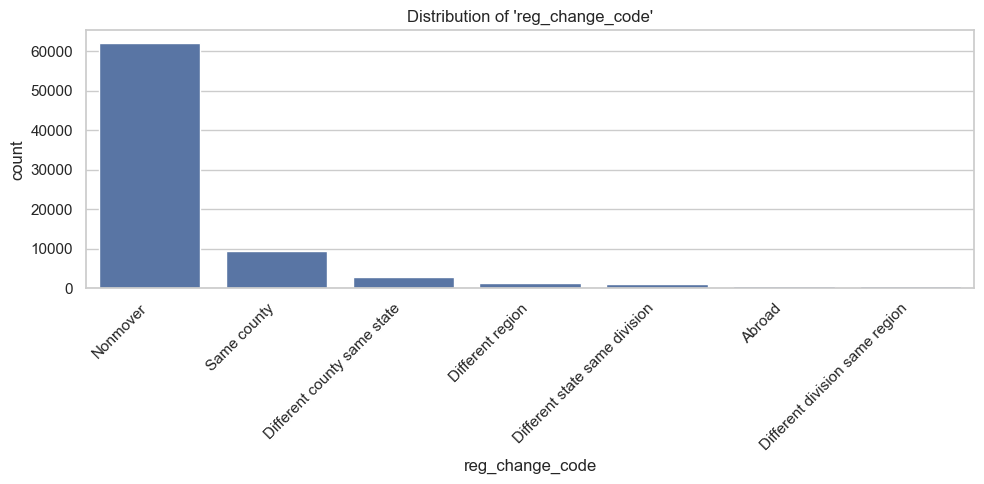


🔹 move_within_reg — Unique values: 8
Top values:
move_within_reg
NaN                            75287
Nonmover                       62191
Same county                     9479
Different county same state     2773
Different state in South         971


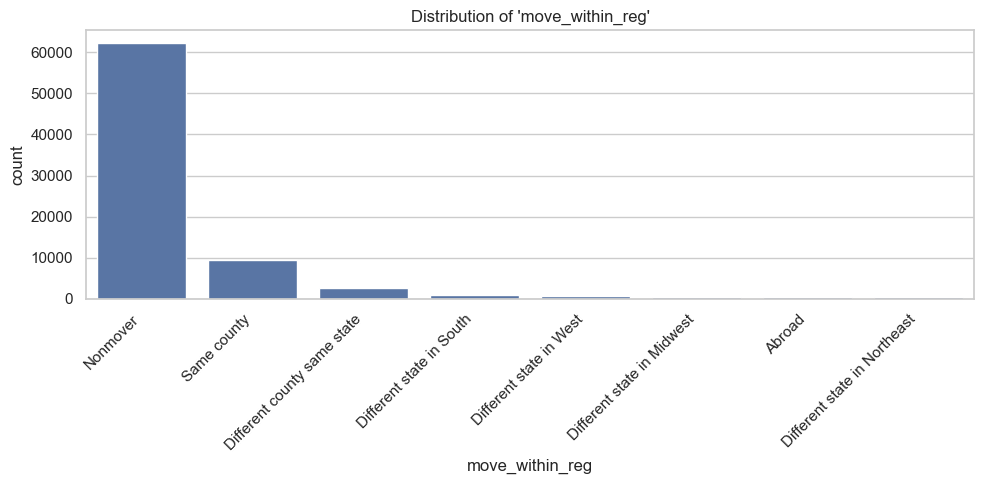


🔹 live_in_this_house_1_year_ago — Unique values: 3
Top values:
live_in_this_house_1_year_ago
Not in universe under 1 year old    75287
Yes                                 62191
No                                  15404


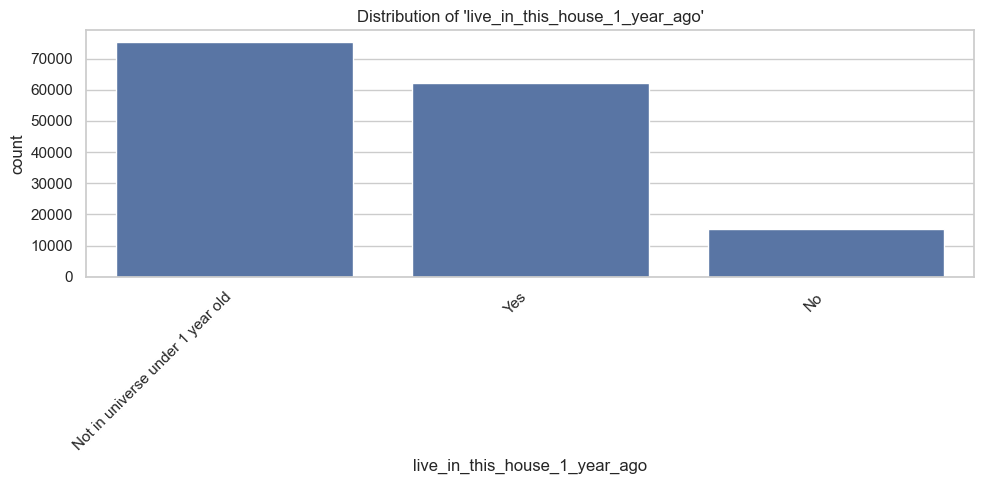


🔹 prev_residence_sunbelt — Unique values: 2
Top values:
prev_residence_sunbelt
NaN    137478
No       9767
Yes      5637


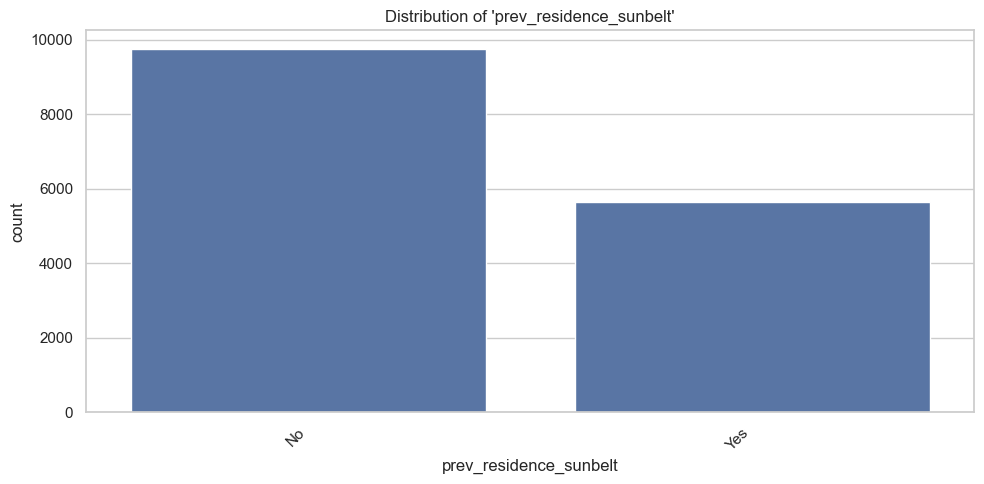


🔹 family_members_under_18 — Unique values: 4
Top values:
family_members_under_18
NaN                       134959
Both parents present       10849
Mother only present         5137
Father only present         1028
Neither parent present       909


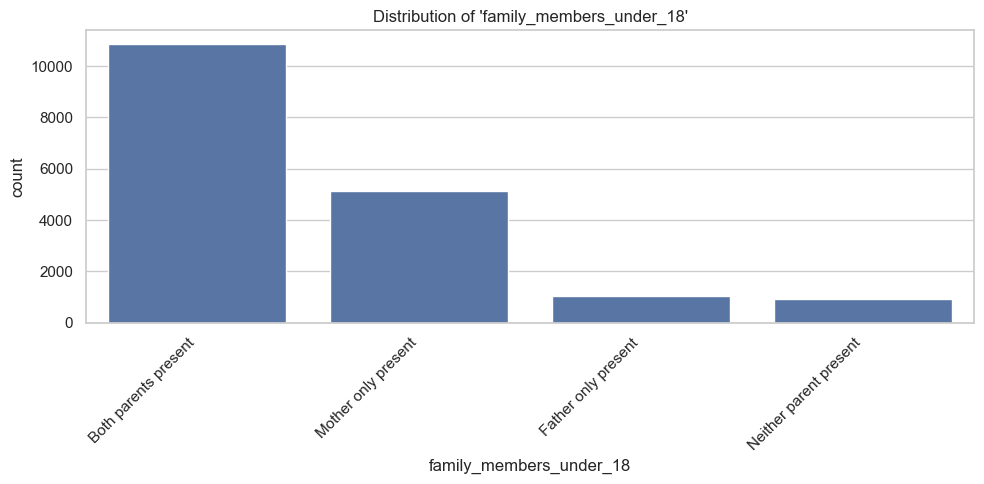


🔹 country_birth_father — Unique values: 42
Top values:
country_birth_father
United-States    115457
Mexico             8120
NaN                6383
Puerto-Rico        2560
Italy              2150


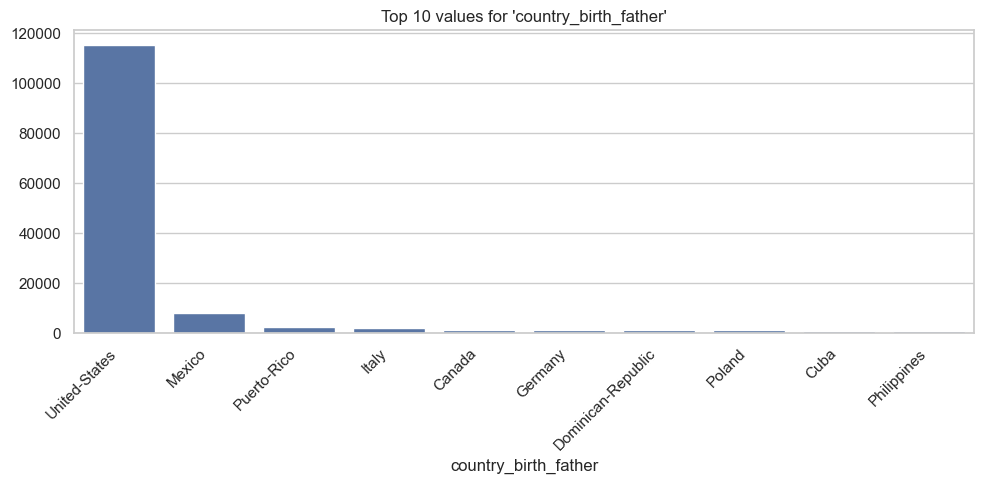


🔹 country_birth_mother — Unique values: 42
Top values:
country_birth_mother
United-States    116603
Mexico             7993
NaN                5810
Puerto-Rico        2378
Italy              1786


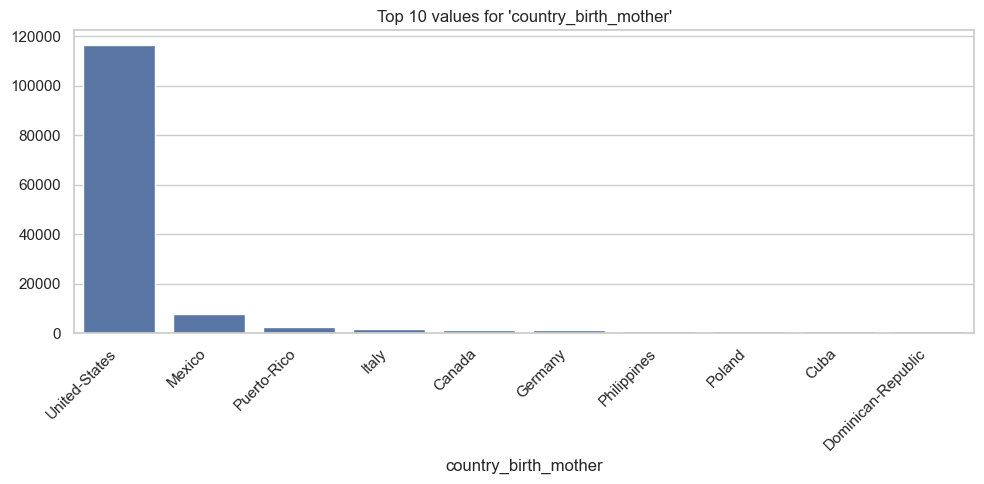


🔹 country_birth_self — Unique values: 42
Top values:
country_birth_self
United-States    130929
Mexico             5379
NaN                3322
Puerto-Rico        1388
Philippines         837


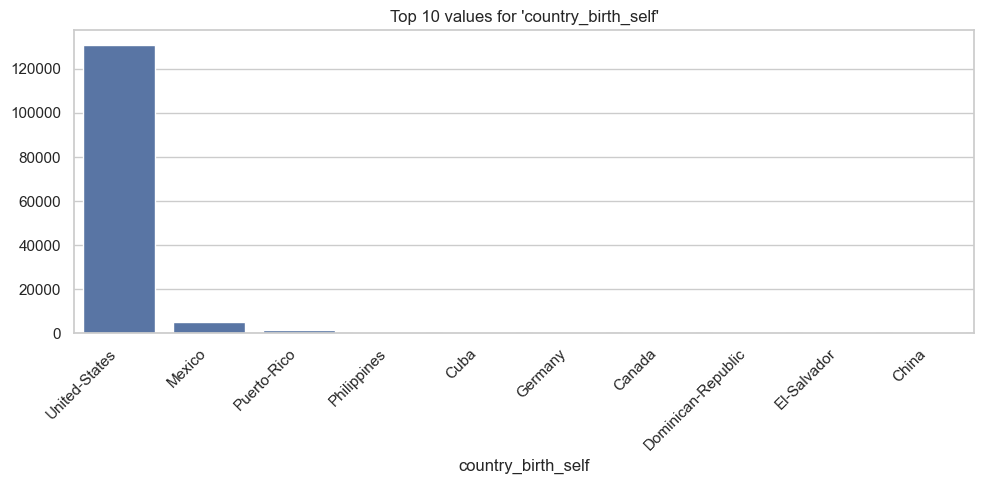


🔹 citizenship — Unique values: 5
Top values:
citizenship
Native- Born in the United States              130932
Foreign born- Not a citizen of U S              12887
Foreign born- U S citizen by naturalization      5829
Native- Born abroad of American Parent(s)        1727
Native- Born in Puerto Rico or U S Outlying      1507


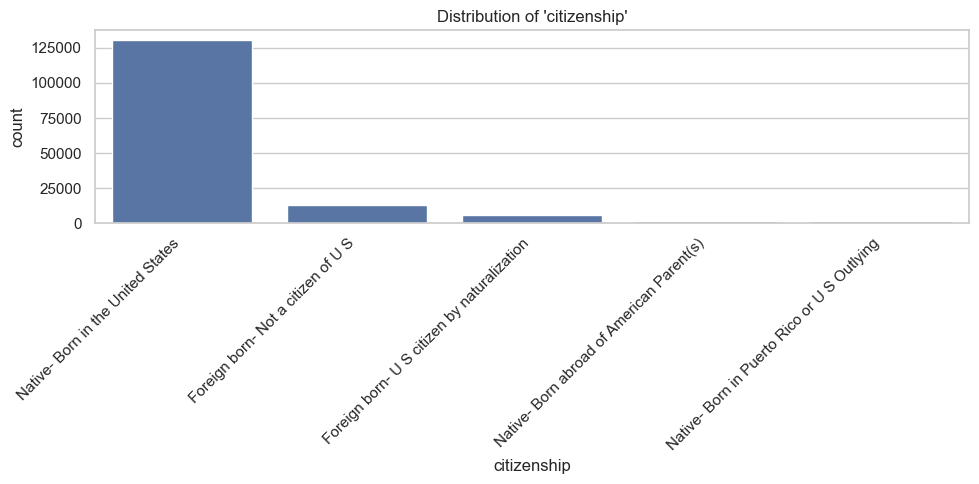


🔹 own_business_or_self_employed — Unique values: 3
Top values:
own_business_or_self_employed
0    134058
2     16126
1      2698


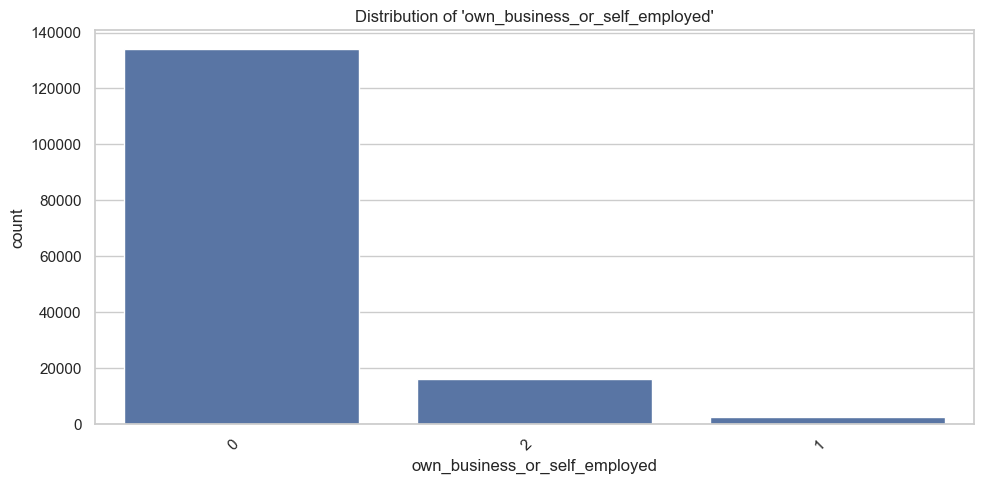


🔹 veterans_admin_questionnaire — Unique values: 2
Top values:
veterans_admin_questionnaire
NaN    150917
No       1575
Yes       390


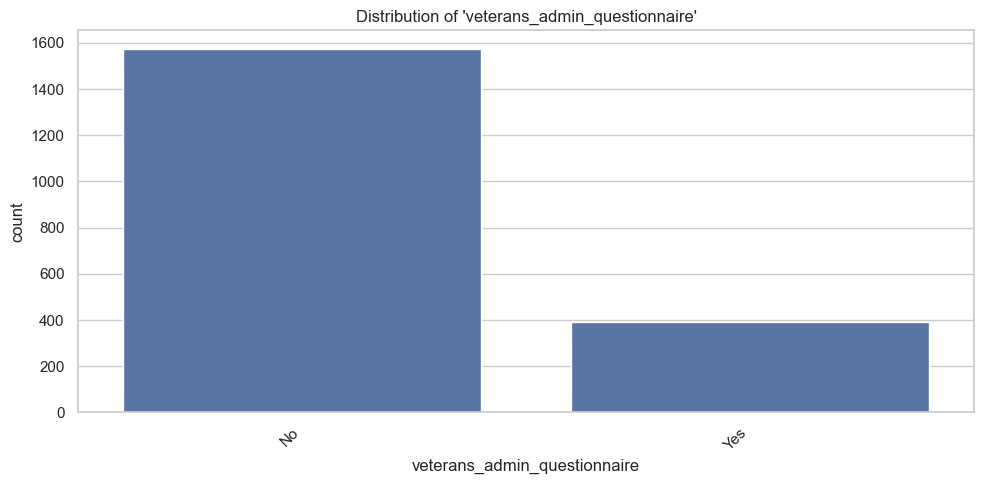


🔹 veterans_benefits — Unique values: 3
Top values:
veterans_benefits
2    138234
0     12683
1      1965


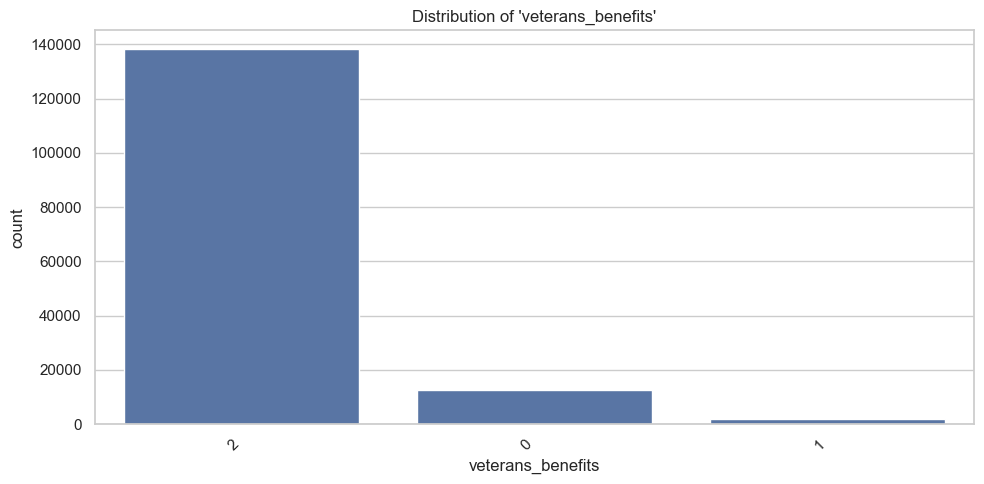


🔹 year — Unique values: 2
Top values:
year
94    77939
95    74943


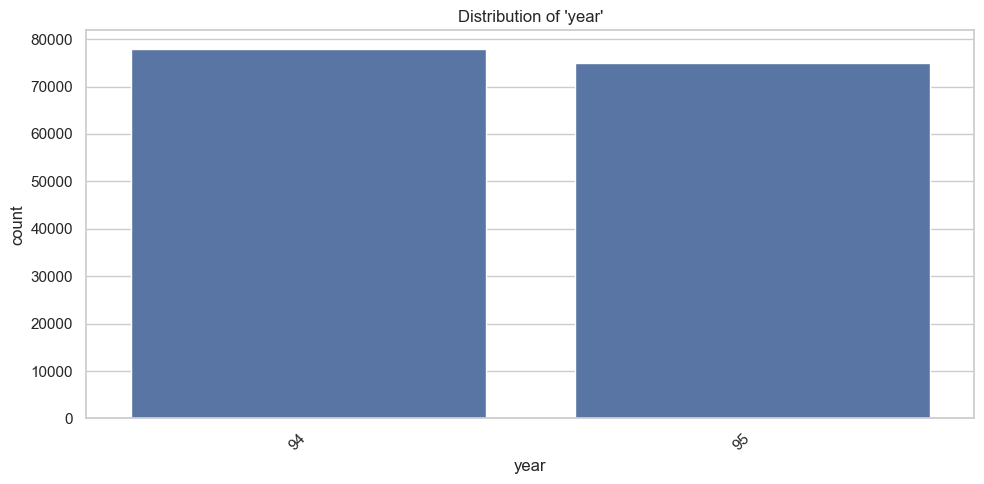


🔹 income — Unique values: 2
Top values:
income
- 50000.    140515
50000+.      12367


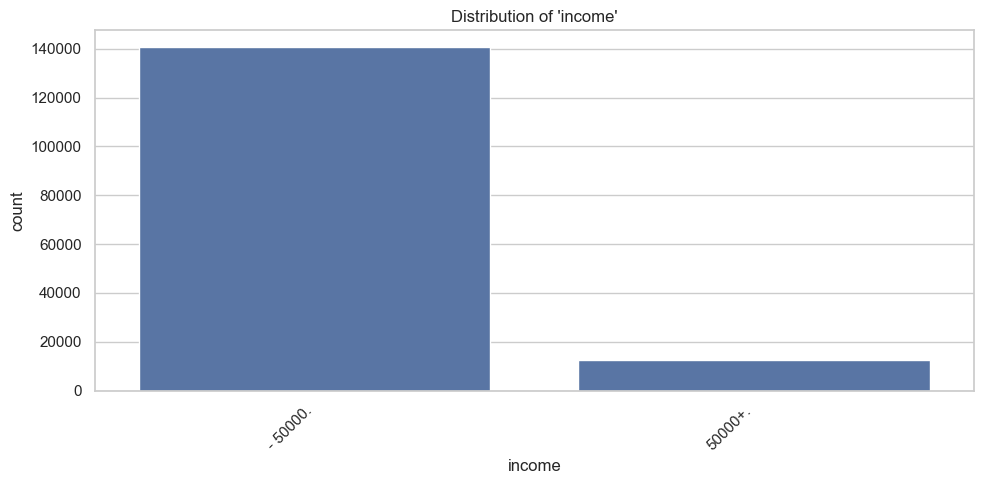

In [10]:
# Sélection des colonnes catégorielles
cat_cols = train_df.select_dtypes(include=['object','category']).columns

# Pour chaque colonne catégorielle
for col in cat_cols:
    n_unique = train_df[col].nunique()
    top_values = train_df[col].value_counts(dropna=False).head(5)

    print(f"\n🔹 {col} — Unique values: {n_unique}")
    print(f"Top values:\n{top_values.to_string()}")

    # Si peu de modalités, on affiche un barplot complet
    if n_unique <= 20:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=train_df, x=col, order=train_df[col].value_counts().index)
        plt.title(f"Distribution of '{col}'")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        # Si beaucoup de modalités, on affiche uniquement les 10 principales
        plt.figure(figsize=(10, 5))
        top10 = train_df[col].value_counts().head(10)
        sns.barplot(x=top10.index, y=top10.values)
        plt.title(f"Top 10 values for '{col}'")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


---
*No outliers detected, but some categories are rare and need to be removed to avoid overfitting*

---

#### B. Identification of missing value patterns

In [9]:
# Summarize missing values per column
missing_counts = train_df.isna().sum()
missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)

missing_percentages = (train_df.isna().mean() * 100).round(2)
missing_percentages = missing_percentages[missing_percentages > 0].sort_values(ascending=False)
# Display summary
print("\nMissing values summary (percentage):\n")
print(missing_percentages)


Missing values summary (percentage):

veterans_admin_questionnaire    98.71
reason_for_unemployment         96.07
enroll_in_edu_last_wk           93.03
state_prev_residence            90.38
prev_residence_sunbelt          89.92
region_prev_residence           89.92
family_members_under_18         88.28
member_of_labor_union           87.54
msa_change_code                 49.52
reg_change_code                 49.25
move_within_reg                 49.25
major_occupation_code           35.67
class_of_worker                 35.42
country_birth_father             4.18
country_birth_mother             3.80
country_birth_self               2.17
hispanic_origin                  0.74
dtype: float64


---
*To simplify modeling and avoid information leakage, columns with more than 85% missing values are dropped from both train and test sets.*

---


#### C. Drop Columns with Excessive Missing Values

In [12]:
def drop_high_na_columns(train_df, test_df, threshold=0.85, verbose=True):
    """
    Drops columns from train and test dataframes where the proportion of missing values in train_df exceeds threshold.
    Returns: cleaned train_df, test_df, and list of dropped columns.
    """
    missing_ratio = train_df.isna().mean()
    cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
    if verbose:
        print(f"Columns with >{int(threshold*100)}% missing values:\n{cols_to_drop}")
    train_df = train_df.drop(columns=cols_to_drop)
    test_df = test_df.drop(columns=cols_to_drop, errors='ignore')
    if verbose:
        print(f"✅ Remaining columns: {train_df.shape[1]}")
    return train_df, test_df, cols_to_drop

In [13]:
train_df, test_df, dropped_cols = drop_high_na_columns(train_df, test_df, threshold=0.85)

Columns with >85% missing values:
['enroll_in_edu_last_wk', 'member_of_labor_union', 'reason_for_unemployment', 'region_prev_residence', 'state_prev_residence', 'prev_residence_sunbelt', 'family_members_under_18', 'veterans_admin_questionnaire']
✅ Remaining columns: 33


### D. Correlation Analysis: 
#### Numeric variables

Examine the correlation matrix for all numerical features to detect highly correlated variables, potential redundancy, and to inform future feature selection steps.


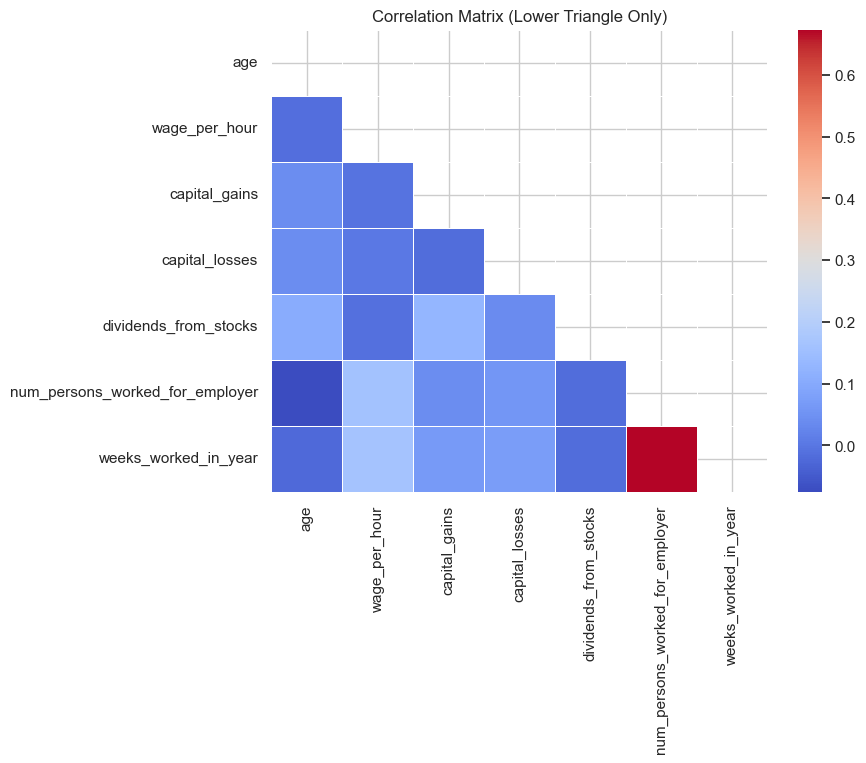


Top correlated pairs (abs value > 0.7):
Series([], dtype: float64)


In [14]:
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('year', errors='ignore')
corr_matrix = train_df[num_cols].corr()

# Plot bottom triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # True pour upper triangle

plt.figure(figsize=(8,6))
sns.heatmap(
    corr_matrix,
    mask=mask,            
    cmap='coolwarm',
    linewidths=0.5,
)
plt.title('Correlation Matrix (Lower Triangle Only)')
plt.show()

# Print significant correlations > 0.7
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # enlève les 1 (auto-corrélation)
print("\nTop correlated pairs (abs value > 0.7):")
print(corr_pairs[corr_pairs > 0.7])

---
*No significant correlations detected*

---

#### Categorical variables

We identify and remove categorical variables that are highly correlated with each other to reduce redundancy and improve model performance.


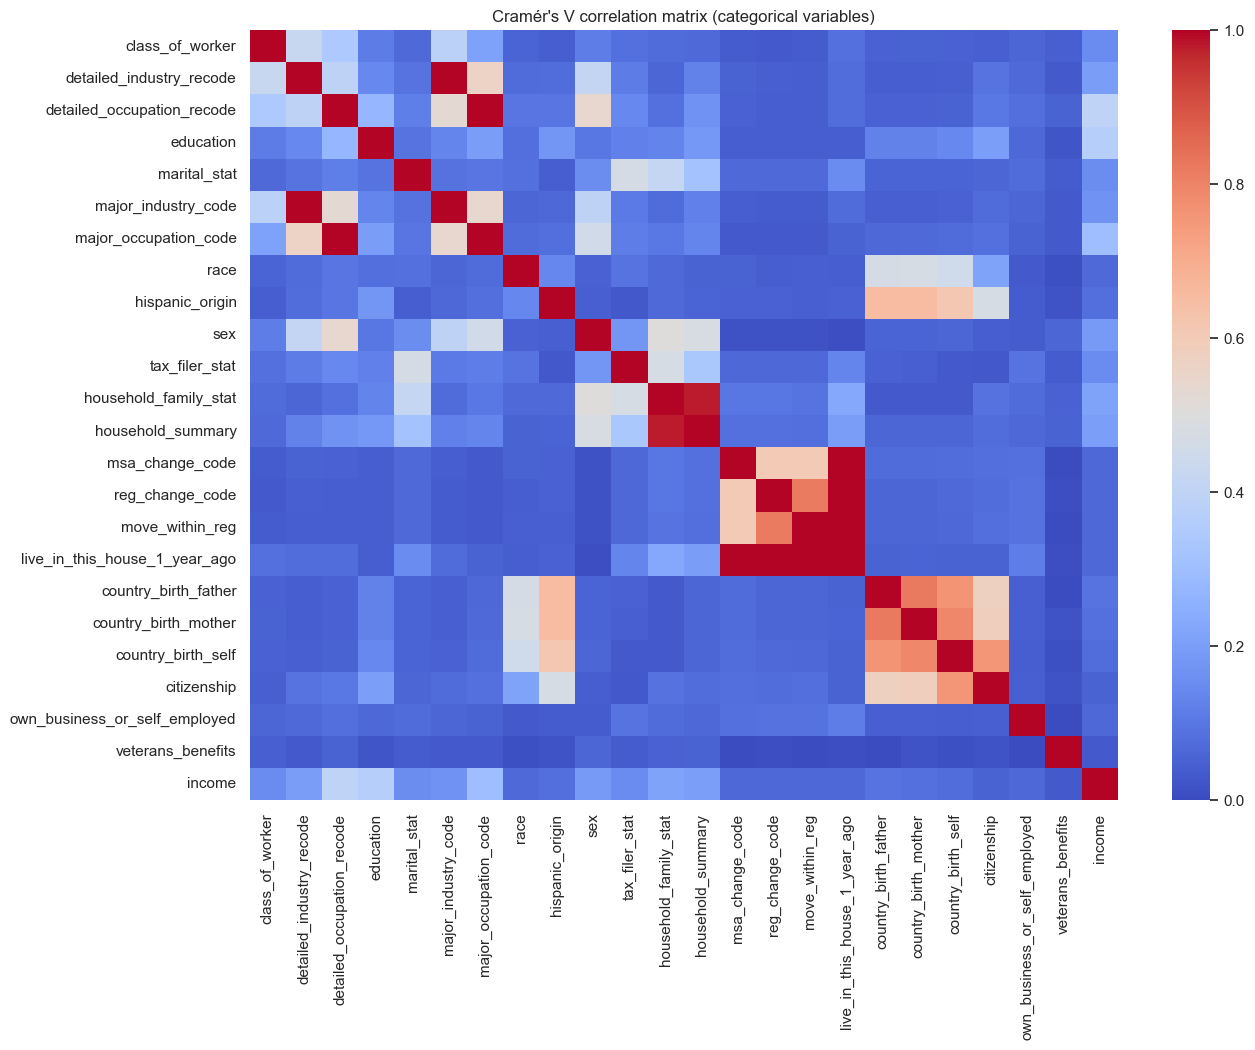

In [16]:
# Step 1: Filter categorical columns with more than one unique value
cat_cols = train_df.select_dtypes(include=['category', 'object']).columns
train_df_no_na = train_df.dropna(subset=cat_cols).copy()
cat_cols = [col for col in cat_cols if train_df_no_na[col].nunique() > 1]

# Step 2: Define Cramér's V function (robust version)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    denom = min((kcorr-1), (rcorr-1))
    if denom <= 0:
        return np.nan
    return np.sqrt(phi2corr / denom)

# Step 3: Compute Cramér's V matrix
cramers_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols)
for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        else:
            try:
                cramers_matrix.loc[col1, col2] = cramers_v(train_df_no_na[col1], train_df_no_na[col2])
            except Exception as e:
                cramers_matrix.loc[col1, col2] = np.nan
cramers_matrix = cramers_matrix.astype(float)

plt.figure(figsize=(14, 10))
sns.heatmap(cramers_matrix, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V correlation matrix (categorical variables)")
plt.show()

In [17]:
# Step 4: Extract variable pairs above a threshold
threshold = 0.85  
high_corr_pairs = []

for col1 in cat_cols:
    for col2 in cat_cols:
        if col1 < col2:  # Avoid duplicates and diagonal
            val = cramers_matrix.loc[col1, col2]
            if pd.notnull(val) and val >= threshold:
                high_corr_pairs.append((col1, col2, val))


df_high_corr = pd.DataFrame(high_corr_pairs, columns=['var1', 'var2', 'cramers_v'])
df_high_corr.sort_values('cramers_v', ascending=False, inplace=True)
print(df_high_corr)


                            var1                   var2  cramers_v
4  live_in_this_house_1_year_ago        reg_change_code   0.999946
3  live_in_this_house_1_year_ago        msa_change_code   0.999946
5  live_in_this_house_1_year_ago        move_within_reg   0.999936
0       detailed_industry_recode    major_industry_code   0.999700
1     detailed_occupation_recode  major_occupation_code   0.999657
2          household_family_stat      household_summary   0.977521


---
To reduce redundancy and improve model robustness, we removed categorical variables that were highly correlated with others, as identified by the Cramér’s V association matrix:

    - reg_change_code
    - msa_change_code
    - move_within_reg
    - detailed_industry_recode
    - detailed_occupation_recode
    - household_family_stat

These variables were found to be almost duplicative of others (e.g., mobility indicators, detailed industry/occupation codes, and family status), providing very similar information.  
By retaining only the most informative and interpretable features, we simplify the dataset, reduce multicollinearity, and enhance the interpretability of our models.

---

In [18]:
def drop_columns(df, columns_to_drop):
    """
    Remove columns from a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns_to_drop (list): List of column names to remove.
        
    Returns:
        pd.DataFrame: DataFrame without the specified columns.
    """
    return df.drop(columns=columns_to_drop, errors='ignore')

In [19]:
COLUMNS_TO_REMOVE = [
    "reg_change_code",
    "msa_change_code",
    "move_within_reg",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "household_family_stat"
]
train_df = drop_columns(train_df, COLUMNS_TO_REMOVE)
test_df = drop_columns(test_df, COLUMNS_TO_REMOVE)


# 3. Preprocessing & Feature Engineering
    A. Handle missing values (impute)
    B. Group rare categories (into "Other")
    C. Encode categorical variables (one-hot encoding)

#### A. Handling missing values
We impute missing values according to variable type:
- Numerical variables: median imputation (robust to extreme values)
- Categorical variables: impute with a new category "Missing"

All imputations are done consistently on both train and test sets.


In [20]:
def impute_missing_values(train_df, test_df):
    # Impute numeric columns with median
    num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_imputer = SimpleImputer(strategy='median')
    train_df[num_cols] = num_imputer.fit_transform(train_df[num_cols])
    test_df[num_cols] = num_imputer.transform(test_df[num_cols])
    
    # Impute categorical columns with "Missing"
    cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
    cat_imputer = SimpleImputer(strategy='constant', fill_value="Missing")
    train_df[cat_cols] = cat_imputer.fit_transform(train_df[cat_cols])
    test_df[cat_cols] = cat_imputer.transform(test_df[cat_cols])
    
    return train_df, test_df

In [21]:
train_df, test_df = impute_missing_values(train_df, test_df)

#### B. Group rare categories 
Group categories with less than 1% presence into "Other" category

In [23]:
def group_rare_categories(df, column, min_freq=0.01):
    freq = df[column].value_counts(normalize=True)
    rare = freq[freq < min_freq]
    if not rare.empty:
        print(f"Rare categories (<{min_freq*100:.1f}%):")
        for cat, pct in rare.items():
            print(f" - {cat}: {pct:.4f} ({pct*100:.2f}%)")
    else:
        print("No rare category detected.")
    df[column] = df[column].replace(rare.index, "Other")
    return df

In [24]:
cat_features = train_df.select_dtypes(include=['category', 'object']).columns.tolist()
high_card_cols = [col for col in cat_features if train_df[col].nunique() > 10]

for col in high_card_cols:
     train_df = group_rare_categories(train_df, col, min_freq=0.01)
     test_df = group_rare_categories(test_df, col, min_freq=0.01)

Rare categories (<1.0%):
 - Doctorate degree(PhD EdD): 0.0083 (0.83%)
 - Less than 1st grade: 0.0052 (0.52%)
Rare categories (<1.0%):
 - Doctorate degree(PhD EdD): 0.0079 (0.79%)
 - Less than 1st grade: 0.0052 (0.52%)
Rare categories (<1.0%):
 - Communications: 0.0077 (0.77%)
 - Utilities and sanitary services: 0.0077 (0.77%)
 - Private household services: 0.0061 (0.61%)
 - Mining: 0.0037 (0.37%)
 - Forestry and fisheries: 0.0012 (0.12%)
 - Armed Forces: 0.0002 (0.02%)
Rare categories (<1.0%):
 - Communications: 0.0075 (0.75%)
 - Utilities and sanitary services: 0.0072 (0.72%)
 - Private household services: 0.0063 (0.63%)
 - Mining: 0.0041 (0.41%)
 - Forestry and fisheries: 0.0013 (0.13%)
 - Armed Forces: 0.0002 (0.02%)
Rare categories (<1.0%):
 - Private household services: 0.0050 (0.50%)
 - Armed Forces: 0.0002 (0.02%)
Rare categories (<1.0%):
 - Protective services: 0.0100 (1.00%)
 - Private household services: 0.0054 (0.54%)
 - Armed Forces: 0.0002 (0.02%)
Rare categories (<1.0%):


#### C. Categorical Variable Encoding 

For tree-based models (CatBoost, LightGBM, XGBoost), categorical features are passed natively. For linear models, we use one-hot encoding for categorical variables.


In [25]:
def one_hot_encode(train_df, test_df, categorical_cols):
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit(train_df[categorical_cols])
    
    # Transform categorical features
    X_train_ohe = encoder.transform(train_df[categorical_cols])
    X_test_ohe = encoder.transform(test_df[categorical_cols])
    
    ohe_cols = encoder.get_feature_names_out(categorical_cols)
    
    # Merge with numeric features
    train_num = train_df.drop(columns=categorical_cols).reset_index(drop=True)
    test_num = test_df.drop(columns=categorical_cols).reset_index(drop=True)
    X_train_final = pd.concat([train_num.reset_index(drop=True), pd.DataFrame(X_train_ohe, columns=ohe_cols)], axis=1)
    X_test_final = pd.concat([test_num.reset_index(drop=True), pd.DataFrame(X_test_ohe, columns=ohe_cols)], axis=1)
    
    return X_train_final, X_test_final, encoder